# Using EcoFOCIpy to process raw field data: SeaGuard II Bench Check

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for RCM-SG (SeaGuard) it is different than the RCM-4/5/7/9/11 Processing pipeline which was developed by D.Pashinski.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [48]:
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ecofocipy.io.rcm_parser as rcm_parser #<- instrument specific
import ecofocipy.io.ncCFsave as ncCFsave
import ecofocipy.metaconfig.load_config as load_config
import ecofocipy.math.geotools as geotools
import ecofocipy.plots.TimeSeriesStickPlot as TSSP

def color_bad_red(x):
    c1 = 'background-color: red'
    c2 = 'background-color: green' 

    cols = x.select_dtypes(np.number).columns
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1[cols] = np.where(x[cols] > 2, c1, c2)

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/Downloads/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'5750-1277-0-2023-03-17T18-05-00.042Z.csv'
instrument = 'RCMSG 5750'
mooring_meta_file = user_data_dir+'logs/20SH-1A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/rcmsg_cf.yaml'
inst_shortname = 'rcmsg'
###############################################################

#init and load data
rcmsg_wop = rcm_parser.rcm_sg()
(rcmsg_wop_data,rcmsg_wop_header) = rcmsg_wop.parse(filename=datafile,datetime_index=True,delimiter=';')

In [4]:
rcmsg_wop_header

['Description;Seaguard II Platform\n',
 'Product Name;SeaGuard II\n',
 'Product Number;5750\n',
 'Serial Number;1277\n',
 'Device ID;5750-1277\n',
 'Session ID;5750-1277-2023-03-17T17:48:03Z\n',
 'Location;\n',
 'Geographic Position;\n',
 'Vertical Position;\n',
 'Owner;\n',
 'Reference;\n',
 ';;Oxygen Optode #4099;;;;;;;Pressure Sensor #2303;;;;;DCS #1594;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;System Parameters;;;;;\n',
 ';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n',
 ';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n',
 ';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n',
 'Record Time;Record Number;Sensor Status;O2Concentration[uM];Status;AirSaturation[%];Status;Temperature[Deg.C];Status;Sensor Status;Pressure[kPa];Status;Temperature[DegC];Status;Sensor Status;Abs Speed[cm/s];Status;Direction[Deg.M];Status;North[cm/s];Status;East[cm/s];Status;Heading[Deg.M];Status;Tilt X[Deg];Status;Tilt Y[Deg];Status;SP Std[cm/s];Status;Strength[dB];Status;Ping

In [18]:
rcmsg_wop_data.sample(5)

,Record Number,Sensor Status,O2Concentration[uM],Status,AirSaturation[%],Status.1,Temperature[Deg.C],Status.2,Sensor Status.1,Pressure[kPa],...,Status.21,Strength Y Trd2[dB],Status.22,Strength Y Trd4[dB],Status.23,Sensor Status.3,Input Voltage[V],Status.24,Memory Used[Bytes],Status.25
date_time,,,,,,,,,,,,,,,,,,,,,
2023-03-17 20:05:00,24,OK,287.7804,OK,97.05857,OK,17.85641,OK,OK,101.7707,...,OK,-69.11590,OK,-69.65071,OK,OK,9.269057,OK,12603392,OK
2023-03-17 18:45:00,8,OK,290.4259,OK,97.06311,OK,17.41660,OK,OK,101.3433,...,OK,-69.14877,OK,-69.68562,OK,OK,9.269057,OK,12603392,OK
2023-03-17 18:35:00,6,OK,290.6960,OK,97.04623,OK,17.36349,OK,OK,101.2784,...,OK,-69.12965,OK,-69.74422,OK,OK,9.269057,OK,12607488,OK
2023-03-17 19:05:00,12,OK,289.7301,OK,97.04075,OK,17.52106,OK,OK,101.5324,...,OK,-69.09256,OK,-69.63818,OK,OK,9.269057,OK,12603392,OK
2023-03-17 19:55:00,22,OK,288.1269,OK,97.07043,OK,17.80402,OK,OK,101.9013,...,OK,-69.14156,OK,-69.66511,OK,OK,9.269057,OK,12603392,OK


In [56]:
def style_ok(v, props=''):
    return props if v == 'OK' else None
rcmsg_wop_data.style.applymap(style_ok, props='color:green;')

,Record Number,Sensor Status,oxy_concM,Status,oxy_percentsat,Status.1,oxy_temperature,Status.2,Sensor Status.1,Pressure[kPa],Status.3,temperature,Status.4,Sensor Status.2,current_speed,Status.5,Direction[Deg.M],Status.6,v_curr_comp,Status.7,u_curr_comp,Status.8,Heading[Deg.M],Status.9,Tilt X[Deg],Status.10,Tilt Y[Deg],Status.11,SP Std[cm/s],Status.12,Strength[dB],Status.13,Ping Count,Status.14,Abs Tilt[Deg],Status.15,Max Tilt[Deg],Status.16,Std Tilt[Deg],Status.17,Strength X[dB],Status.18,Strength Y[dB],Status.19,Strength X Trd1[dB],Status.20,Strength X Trd3[dB],Status.21,Strength Y Trd2[dB],Status.22,Strength Y Trd4[dB],Status.23,Sensor Status.3,Input Voltage[V],Status.24,Memory Used[Bytes],Status.25
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-03-17 18:25:00,4,OK,290.942600,OK,97.020080,OK,17.309790,OK,OK,101.355000,OK,17.292420,OK,OK,8.045154,OK,255.655700,OK,-1.993164,OK,-7.794343,OK,287.051700,OK,-0.812256,OK,-1.385408,OK,89.206080,OK,-69.522350,OK,150,OK,1.605991,OK,1.663540,OK,0.024363,OK,-69.666770,OK,-69.377930,OK,-69.743010,OK,-69.590550,OK,-69.154340,OK,-69.620130,OK,OK,9.269057,OK,12615680,OK
2023-03-17 18:30:00,5,OK,290.744900,OK,97.012180,OK,17.338530,OK,OK,101.397600,OK,17.320400,OK,OK,19.480800,OK,336.908100,OK,17.919930,OK,-7.640515,OK,287.037500,OK,-0.819563,OK,-1.382055,OK,91.307590,OK,-69.495160,OK,150,OK,1.606794,OK,1.676548,OK,0.024418,OK,-69.636780,OK,-69.353520,OK,-69.733830,OK,-69.564510,OK,-69.041180,OK,-69.619540,OK,OK,9.274944,OK,12603392,OK
2023-03-17 18:35:00,6,OK,290.696000,OK,97.046230,OK,17.363490,OK,OK,101.278400,OK,17.345920,OK,OK,11.063360,OK,58.722020,OK,5.743994,OK,9.455394,OK,287.027600,OK,-0.819154,OK,-1.382112,OK,99.002460,OK,-69.567340,OK,150,OK,1.606619,OK,1.665892,OK,0.022106,OK,-69.677240,OK,-69.457430,OK,-69.766690,OK,-69.580310,OK,-69.129650,OK,-69.744220,OK,OK,9.269057,OK,12607488,OK
2023-03-17 18:40:00,7,OK,290.510600,OK,97.037950,OK,17.390090,OK,OK,101.454200,OK,17.370000,OK,OK,6.487258,OK,81.474360,OK,0.961750,OK,6.415572,OK,286.996800,OK,-0.808107,OK,-1.372851,OK,94.055680,OK,-69.546620,OK,150,OK,1.593060,OK,1.648176,OK,0.025545,OK,-69.663710,OK,-69.429530,OK,-69.725800,OK,-69.601520,OK,-69.138990,OK,-69.690670,OK,OK,9.274944,OK,12603392,OK
2023-03-17 18:45:00,8,OK,290.425900,OK,97.063110,OK,17.416600,OK,OK,101.343300,OK,17.396020,OK,OK,12.318630,OK,348.858400,OK,12.086460,OK,-2.380391,OK,287.029500,OK,-0.804731,OK,-1.370537,OK,98.200610,OK,-69.533140,OK,150,OK,1.589326,OK,1.639605,OK,0.022619,OK,-69.641920,OK,-69.424360,OK,-69.753720,OK,-69.541470,OK,-69.148770,OK,-69.685620,OK,OK,9.269057,OK,12603392,OK
2023-03-17 18:50:00,9,OK,290.295800,OK,97.066310,OK,17.439770,OK,OK,101.484000,OK,17.420630,OK,OK,39.622080,OK,21.070450,OK,36.972910,OK,14.244750,OK,287.078400,OK,-0.806177,OK,-1.368183,OK,98.805110,OK,-69.592710,OK,150,OK,1.588034,OK,1.639724,OK,0.024543,OK,-69.666410,OK,-69.519000,OK,-69.755790,OK,-69.588250,OK,-69.173940,OK,-69.713120,OK,OK,9.274944,OK,12603392,OK
2023-03-17 18:55:00,10,OK,290.180900,OK,97.082340,OK,17.466760,OK,OK,101.404100,OK,17.450410,OK,OK,31.307980,OK,341.120800,OK,29.623700,OK,-10.130440,OK,287.031700,OK,-0.810427,OK,-1.373909,OK,95.252020,OK,-69.575460,OK,150,OK,1.595124,OK,1.649126,OK,0.024388,OK,-69.717490,OK,-69.433430,OK,-69.838960,OK,-69.608280,OK,-69.119670,OK,-69.686680,OK,OK,9.274944,OK,12603392,OK
2023-03-17 19:00:00,11,OK,289.991800,OK,97.074370,OK,17.494220,OK,OK,101.534400,OK,17.476950,OK,OK,12.367180,OK,306.678500,OK,7.387219,OK,-9.918477,OK,287.064000,OK,-0.808716,OK,-1.374881,OK,101.313700,OK,-69.549800,OK,150,OK,1.595096,OK,1.646394,OK,0.023258,OK,-69.656300,OK,-69.443290,OK,-69.780050,OK,-69.550880,OK,-69.166360,OK,-69.698960,OK,OK,9.274944,OK,12603392,OK
2023-03-17 19:05:00,12,OK,289.730100,OK,97.040750,OK,17.521060,OK,OK,101.532400,OK,17.506470,OK,OK,20.937210,OK,358.980400,OK,20.933900,OK,-0.372556,OK,287.108700,OK,-0.813985,OK,-1.378206,OK,100.734200,OK,-69.522600,OK,150,OK,1.600595,OK,1.652564,OK,0

## Oxygen and other ancillary sensor adjusments

Oxygen units should be adjusted and salinity corrections as we initiallize oxygen sensors as if in a 0 PSU environment.  Without a cond cell on board, this needs a secondary instrument.  See QC section below

## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    
    
***Half Hour Sample - rounded/truncated***

In [ ]:
rcmsg_wop_data.index = rcmsg_wop_data.index.round(freq='1H')
rcmsg_wop_data

In [ ]:
rcmsg_wop_data.plot(figsize=(16,2),legend=False)

## Visual QC of ancillary parameters

We wont keep all the ancillary parameters as they are usually just used for QC of the currents (and are done in the aanderaa software)... we can put them in the preliminary csv file though... anyways, some quick visuals are below to inspire further investigation.

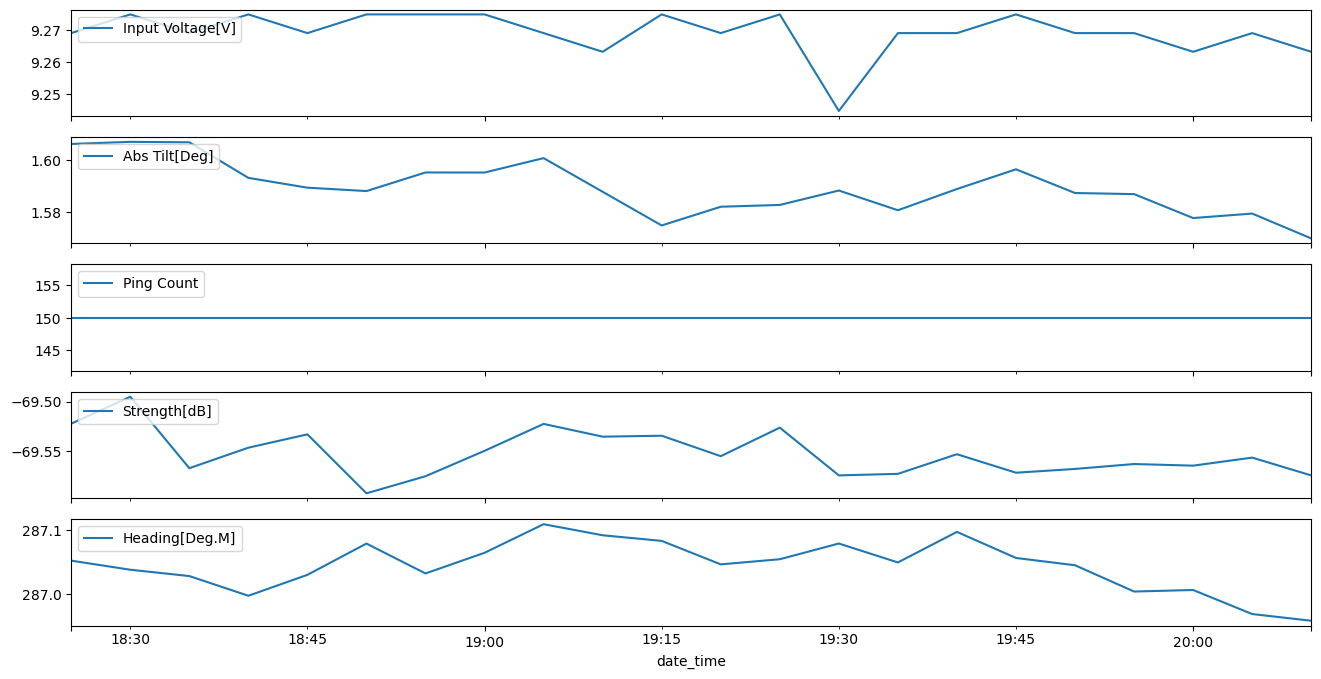

In [23]:
plt_sub = rcmsg_wop_data[['Input Voltage[V]','Abs Tilt[Deg]','Ping Count','Strength[dB]','Heading[Deg.M]']]

fig, ax = plt.subplots(nrows=len(plt_sub.columns), sharex=True, figsize=(16,8))

for count,parameter in enumerate(plt_sub.columns):
    plt_sub[parameter].plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')
    

In [26]:
#rcmsg data uses header info to name variables... but we want standard names from the dictionary I've created, so we need to rename column variables appropriately
#rename values to appropriate names, if a value isn't in the .yaml file, you can add it

#TODO: Manage ancillary instrumentation
rcmsg_wop_data = rcmsg_wop_data.rename(columns={'Temperature[DegC]':'temperature',
                        'O2Concentration[uM]':'oxy_concM',
                        'AirSaturation[%]':'oxy_percentsat',
                        'East[cm/s]':'u_curr_comp',
                        'North[cm/s]':'v_curr_comp',
                        'Abs Speed[cm/s]':'current_speed',
                        'Temperature[Deg.C]':'oxy_temperature', #notice the '.' in the units... this seems to identify the oxy temp
                        })

### add a column for oxy_conc
# rcmsg_wop_data.insert(0,'oxy_conc',np.nan)

rcmsg_wop_data.sample()


,Record Number,Sensor Status,oxy_concM,Status,oxy_percentsat,Status.1,oxy_temperature,Status.2,Sensor Status.1,Pressure[kPa],...,Status.21,Strength Y Trd2[dB],Status.22,Strength Y Trd4[dB],Status.23,Sensor Status.3,Input Voltage[V],Status.24,Memory Used[Bytes],Status.25
date_time,,,,,,,,,,,,,,,,,,,,,
2023-03-17 19:35:00,18,OK,288.7486,OK,97.05203,OK,17.69051,OK,OK,101.6547,...,OK,-69.15978,OK,-69.65629,OK,OK,9.269057,OK,12603392,OK


/Users/bell/Programs/EcoFOCIpy/src/ecofocipy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)


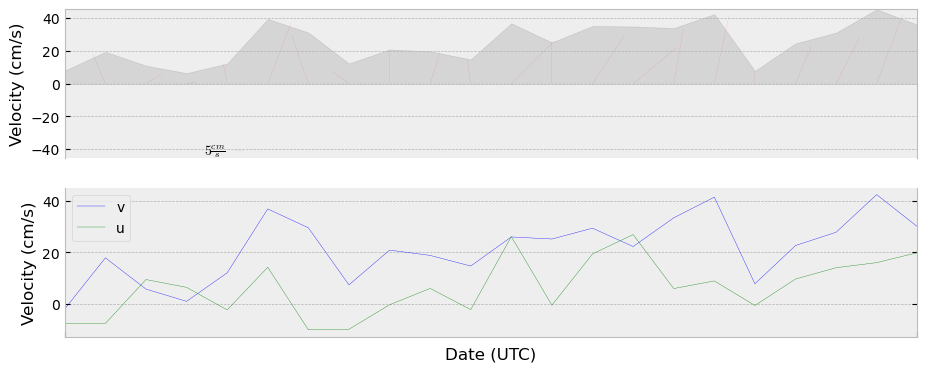

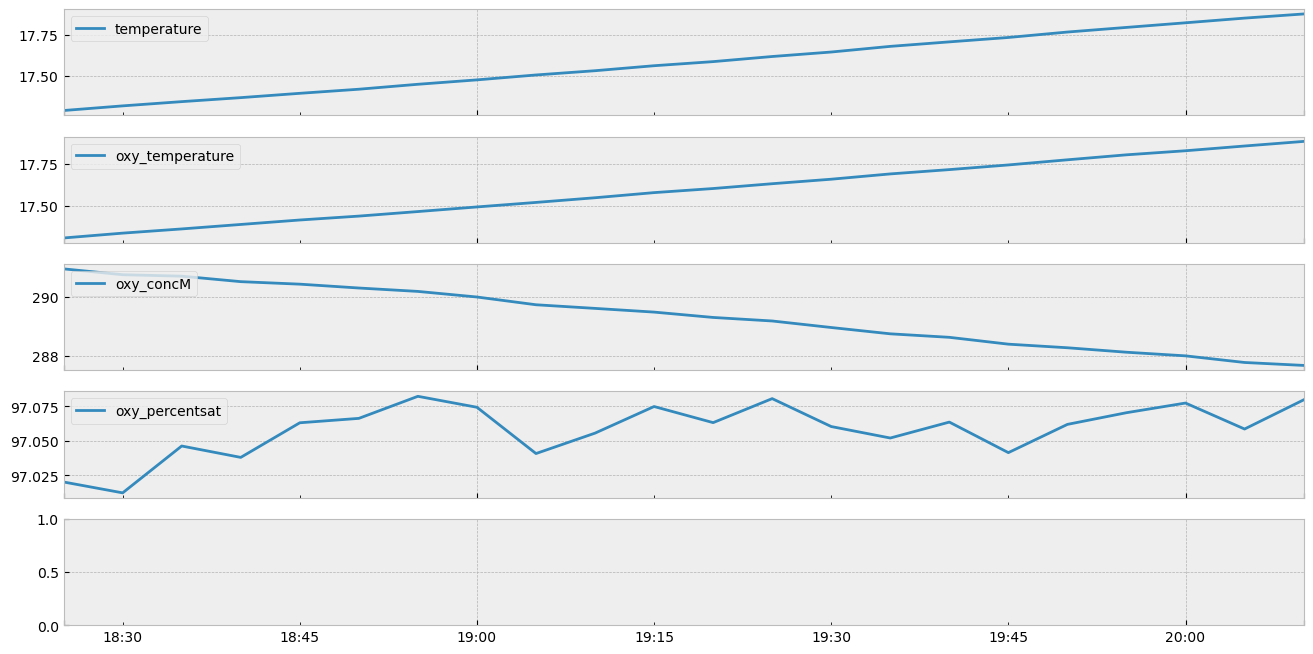

In [28]:
stickplot = TSSP.Timeseries1dStickPlot()
fig,ax = stickplot.plot(rcmsg_wop_data.index,udata=rcmsg_wop_data['u_curr_comp'],vdata=rcmsg_wop_data['v_curr_comp'], rotate=0)

fig, ax = plt.subplots(nrows=len(plt_sub.columns), sharex=True, figsize=(16,8))
plt_sub = rcmsg_wop_data[['temperature','oxy_temperature','oxy_concM','oxy_percentsat']]
for count,parameter in enumerate(plt_sub.columns):
    plt_sub[parameter].plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')